# Plant Seedlings Classification
## Determine the species of a seedling from an image

1. Choosing learning rate
1. Data augmentation



1. recompute=True
1. Use lr_find() to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use lr_find() again
1. Train full network with cycle_mult=2 until over-fitting

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy m

In [25]:
#PATH = "../../data/plant_seeding_clf/"
PATH = f'../../data/plant_seedling_classify/'
sz=224

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

NameError: name 'PWD' is not defined

In [23]:
os.listdir(PATH)


['sample_submission.csv', 'test', 'train']

In [26]:
folders = os.listdir(f'{PATH}train')
folders

['Cleavers',
 'Sugar beet',
 'Scentless Mayweed',
 'Loose Silky-bent',
 'Maize',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Fat Hen',
 'Charlock',
 'Common wheat',
 'Black-grass',
 'Common Chickweed']

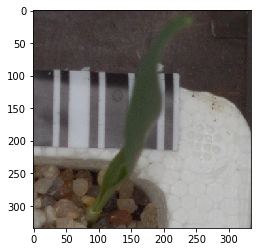

In [27]:
files = os.listdir(f'{PATH}test')
img = plt.imread(f'{PATH}test/{files[0]}')
plt.imshow(img);

In [28]:
def copy_or_move_with_subdirs(subdir_lst, src, dst, r, move=False):
    do = shutil.move if move else shutil.copy
    for subdir in subdir_lst:
        os.makedirs(os.path.join(dst, subdir))
        files = glob(os.path.join(src, subdir, '*'))
        np.random.shuffle(files)
        for f in files[:int(len(files) * r)]:
            do(f, os.path.join(dst, subdir, os.path.split(f)[1]))

In [29]:
def create_val(path, folders, r):
    """ Takes a path to a dataset and creates a validation set of specified size

    Note - this changes the dataset at <path> by moving files to the val set

    Parameters:
    -----------
    path: dataset path
    r (float): proportion of examples to use for validation, in the range from 0 to 1

    """
    val_path = os.path.join(os.path.split(path)[0], 'valid')
    dump_path = os.path.join(os.path.split(path)[0], 'dump')
    subdirs = [os.path.split(p)[1] for p in glob(os.path.join(path + 'train/', '*'))]
    # in prod need set move=True
    copy_or_move_with_subdirs(subdirs, path + 'train/', dump_path, r, move=False)
    copy_or_move_with_subdirs(subdirs, path + 'train/', val_path, r, move=True)

In [30]:
if not os.path.isdir(f'{PATH}valid'):
    print('Create valid data set')
    create_val(f'{PATH}', folders, 0.2)

Create valid data set


In [31]:
os.listdir(PATH)

['dump', 'sample_submission.csv', 'test', 'valid', 'train']

In [32]:
#TODO: here need check mulival clf
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


epoch      trn_loss   val_loss   accuracy                 
    0      1.582866   0.961676   0.692714  
    1      1.113319   0.74479    0.750792                 



[array([0.74479]), 0.7507919750973944]

In [33]:
img.shape

(334, 334, 3)

In [34]:
data.val_y

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3

In [35]:
data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [36]:
log_preds = learn.predict()
log_preds.shape

(947, 12)

Select lern rate

In [37]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [38]:
lrf=learn.lr_find()

 87%|████████▋ | 52/60 [00:00<00:00, 57.24it/s, loss=2.49]


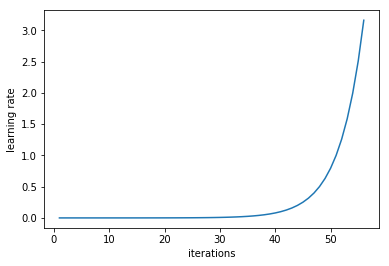

In [39]:
learn.sched.plot_lr()

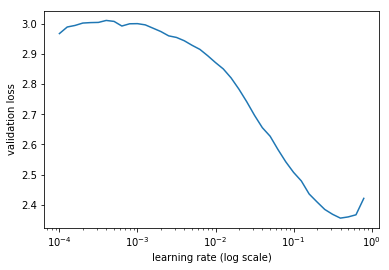

In [40]:
learn.sched.plot()

In [ ]:
Augmentation transform

In [41]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [42]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [43]:
ims = np.stack([get_augs() for i in range(6)])

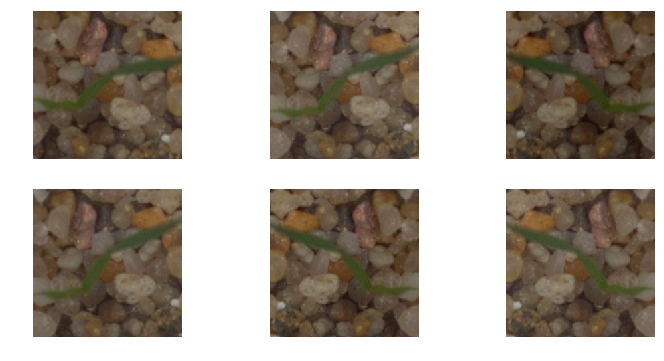

In [44]:
plots(ims, rows=2)

In [45]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [46]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.567202   0.923993   0.690602  



[array([0.92399]), 0.6906019012427003]

In [47]:
learn.precompute=False

In [48]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.086123   0.7937     0.733897  
    1      1.008368   0.695964   0.778247                  
    2      0.942382   0.658684   0.785639                  



[array([0.65868]), 0.7856388599341372]

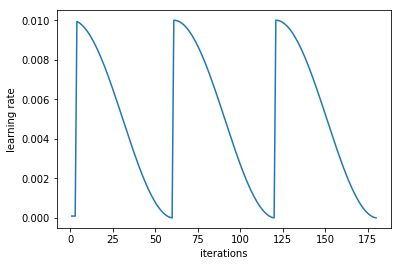

In [49]:
learn.sched.plot_lr()

In [50]:
learn.save('224_lastlayer')

In [51]:
learn.load('224_lastlayer')

### Fine-tuning and differential learning rate annealing

In [52]:
learn.unfreeze()

In [53]:
lr=np.array([1e-4,1e-3,1e-2])

In [54]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.811558   0.473031   0.838437  
    1      0.528298   0.274219   0.897571                  
    2      0.371185   0.255896   0.910243                  
    3      0.299208   0.220615   0.915523                  
    4      0.255713   0.179553   0.931362                  
    5      0.212758   0.169723   0.93981                   
    6      0.195272   0.172734   0.941922                  



[array([0.17273]), 0.9419218585634684]

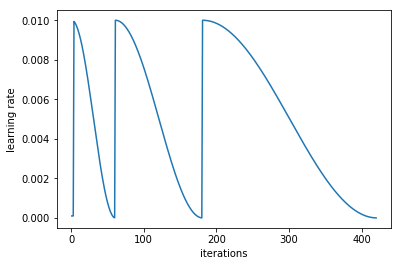

In [55]:
learn.sched.plot_lr()

In [56]:
learn.save('224_all')

In [57]:
learn.load('224_all')

In [58]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [59]:
accuracy_np(probs, y)

0.9472016895459345

In [64]:
learn.predict()

array([[ -1.08246,  -7.89459,  -6.5757 , ...,  -7.58243,  -7.14111,  -7.3253 ],
       [ -0.18831, -11.21344, -11.44194, ..., -12.90478,  -9.45883,  -7.94641],
       [ -0.63859, -13.24354, -11.05065, ..., -14.14031, -11.88313, -10.61024],
       ...,
       [ -6.20554,  -7.22496,  -9.4419 , ..., -10.0006 , -10.49423,  -0.01523],
       [-11.0113 , -12.52987, -10.16602, ..., -12.46995, -16.07065,  -0.00096],
       [-13.11205, -12.55107, -13.03217, ..., -13.32865, -14.70837,  -0.00133]], dtype=float32)

In [65]:
probs

array([[0.30811, 0.00046, 0.00096, ..., 0.0003 , 0.00041, 0.00056],
       [0.47514, 0.00005, 0.00005, ..., 0.00001, 0.00104, 0.00019],
       [0.37709, 0.00001, 0.00006, ..., 0.00001, 0.00005, 0.00011],
       ...,
       [0.01135, 0.0044 , 0.0003 , ..., 0.0001 , 0.00018, 0.94003],
       [0.00002, 0.00001, 0.00008, ..., 0.00001, 0.     , 0.99708],
       [0.     , 0.00001, 0.     , ..., 0.     , 0.     , 0.99743]], dtype=float32)